In [140]:
import re
import srt 
import glob
import pandas as pd
import os
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import spacy

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    HalvingRandomSearchCV,
    GridSearchCV
)
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer
)

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import NearMiss 

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [141]:
DATA_PATH = 'English_level/data_all'

HTML = r'<.*?>'
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Z ]+[\)\]]'
LETTERS = r'[^a-zA-Z\'.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'

YEAR_SRT = r'(\(\d{4}\))'
CLEAN_TEXT = r'[^a-z\s\|]'

def clean_subs(subs):
    txt = re.sub(HTML, ' ', subs) #html тэги меняем на пробел
    txt = re.sub(TAG, ' ', txt) #тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) #комменты меняем на пробел
    txt = re.sub(LETTERS, ' ', txt) #все что не буквы меняем на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    txt = re.sub(DOTS, r'.', txt)  #многоточие меняем на точку
    return txt

### Предобработка данных

Читаем файлы, создаем переменные:
dframes - обьект, связывающий имена файлов с датафреймами субтитров.
films - датафрейм с именами фильмов и классификацией

In [142]:
dframes = {}
files = glob.glob(f'{DATA_PATH}/Subtitles_all/*.srt')

for filename in files:
    try:
        with open(filename) as f:
            #удаляем все что не ascii символы   
            subtitle_generator = srt.parse(f.read().encode('ascii', 'ignore').decode())
            #удаляем первый и последний субтитр (обычно это реклама)
            df = pd.DataFrame(list([[item.start, item.end, item.content] for item in subtitle_generator][1:-1]), columns=['start','end','content'])
            df['content'] = df['content'].apply(clean_subs)
            df['content'] = df['content'].str.strip().replace('', np.nan).str.lower()
            df.dropna(subset=['content'], inplace=True)
            df.reset_index(drop=True, inplace=True)

            dframes[os.path.basename(f.name)] = df

    except srt.SRTParseError as e:
        print(filename, e)
        
films = pd.DataFrame([n for n in dframes], columns=['name'])
films['year'] = films['name'].str.extract(YEAR_SRT, flags=0)
films['parsed_name'] = films.apply(lambda x: x['name'].replace(str(x['year']), '').replace('_', ' ').replace('.srt', ''), axis=1)

labels = pd.read_csv(f'{DATA_PATH}/labels_all.csv')

In [143]:
films

,name,year,parsed_name
0,10_Cloverfield_lane(2016).srt,(2016),10 Cloverfield lane
1,10_things_I_hate_about_you(1999).srt,(1999),10 things I hate about you
2,Aladdin(1992).srt,(1992),Aladdin
3,All_dogs_go_to_heaven(1989).srt,(1989),All dogs go to heaven
4,An_American_tail(1986).srt,(1986),An American tail
...,...,...,...
112,Warm_bodies(2013).srt,(2013),Warm bodies
113,Westworld_scenes_of_Dr_Robert_Ford.srt,NaN,Westworld scenes of Dr Robert Ford
114,We_are_the_Millers(2013).srt,(2013),We are the Millers
115,While_You_Were_Sleeping(1995).srt,(1995),While You Were Sleeping


In [144]:
for index in labels.index:
    item = labels.loc[index, 'Movie']
    found = process.extractOne(item, films['parsed_name'])
    labels.loc[index, ['found', 'probability', 'index']] = found

labels['index'] = labels['index'].astype(int)
films = labels.set_index('index').join(films)

def getClass(title):
    if title.find('C1') >= 0:
        return 'C1'
    if title.find('B2') >= 0:
        return 'B2'
    if title.find('B1') >= 0:
        return 'B1'
    if title.find('A2+') >= 0:
        return 'A2/A2+'
    
films['Level'] = films['Level'].apply(getClass)
films = films[['Movie', 'Level', 'name']]
films.columns = ['movie', 'level', 'name']
display(films)

,movie,level,name
index,,,
37,Forrest Gump,B1,Forrest_Gump(1994).srt
36,Finding Nemo\n,A2/A2+,Finding_Nemo(2003).srt
21,Cast away\n,A2/A2+,Cast_away(2000).srt
91,The invisible man (2020)\n,A2/A2+,The_invisible_man(2020).srt
8,Back to the future\n,A2/A2+,Back_to_the_future(1985).srt
...,...,...,...
48,Klaus,C1,Klaus(2019).srt
67,Ocean’s Eleven,C1,Oceans_Eleven(2001).srt
68,Ocean’s Twelve,C1,Oceans_Twelve(2004).srt


Создаем вспомогательные функции для лемматизации, обучения модели и построения матрицы.

In [145]:
nlp = spacy.load('en_core_web_lg')
def lemmatize(text):    
    doc = nlp(text)
    
    lemmatized_text = ' '.join(['' if token.is_stop else token.lemma_ for token in doc])
    lemmatized_text = re.sub(CLEAN_TEXT, ' ', lemmatized_text)
    lemmatized_text = re.sub(SPACES, r'\1', lemmatized_text)

    return lemmatized_text

def remove_names(text):
    doc = nlp(text)
    newString = text
    for e in reversed(doc.ents):
        if e.label_ == "PERSON": # Only if the entity is a PERSON
            newString = newString[:e.start_char] + newString[e.start_char + len(e.text):]
    return newString

In [146]:
def search_best_estimator(pipeline, param_grid, x, y):
    hrs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1_weighted',
        cv=3,
        # n_candidates="exhaust",
        # factor=5,
        n_jobs=-1,
        verbose=2
    )
    _ = hrs.fit(x, y)
    return hrs.best_estimator_

In [147]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(8,5))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

In [148]:
for index in films.index:
    name = films.loc[index, 'name']
    text = '|'.join(dframes[name]['content'])
    result = remove_names(lemmatize(text)).split('|')
    dframes[name]['content'] = pd.Series(result)
    dframes[name] = dframes[name].dropna(subset=['content']).reset_index(drop=True)

In [149]:
content = []
titles = []
mean = []
median = []
split_factors = 1

for name in dframes:
    df_content = dframes[name]['content']
    size = df_content.size // split_factors
    for i in range(split_factors):
        titles.append(name)
        dframes[name]['content'].str.split(' ').apply(lambda x: len(x)) / (dframes[name].end - dframes[name].start).dt.total_seconds()
        df_part = dframes[name][i * size : (i+1) * size]
        df_div = df_part['content'].str.split(' ').apply(lambda x: len(x)) / (df_part['end'] - df_part['start']).dt.total_seconds()
        mean.append(df_div[(df_div > 0.1) & (df_div < 5)].mean())
        median.append(df_div[(df_div > 0.1) & (df_div < 5)].median())
        content.append(''.join(df_content[i * size : (i+1) * size]))

In [150]:
df_films_splitted = films.merge(pd.DataFrame(data={'name':titles, 'content':content, 'mean': mean, 'median': median}), on='name')
df_films_splitted = df_films_splitted[['name', 'level', 'content', 'mean', 'median']].reset_index(drop=True)

In [151]:
df_films_splitted['level'].value_counts()

B1        40
B2        38
A2/A2+    25
C1         8
Name: level, dtype: int64

In [152]:
words = pd.read_csv(f'Parsed/words.csv', index_col=[0])

Fitting 3 folds for each of 448 candidates, totalling 1344 fits


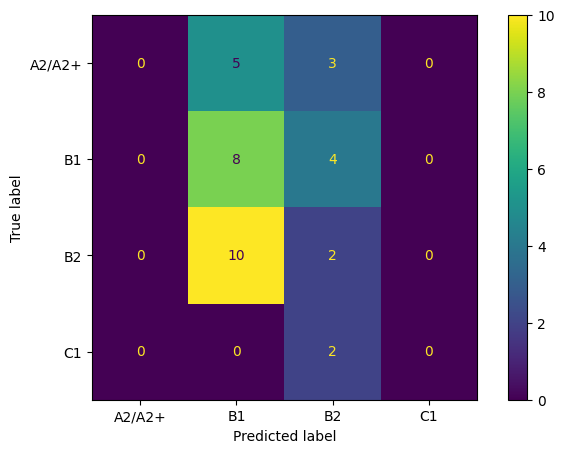

447


In [155]:
x, y = df_films_splitted['content'].tolist(), df_films_splitted['level'].tolist()

# vocabulary=words['name'].str.strip().str.lower().unique()
pipeline = Pipeline(
    steps = [("tfidf", TfidfVectorizer() ),("base", RandomForestClassifier() )]
)

param_grid = {
    "tfidf__min_df": [i for i in range(30,50,5)],
    "tfidf__max_df": [i for i in range(100,500,30)],
    "base__n_estimators": [i for i in range(150,250,50)],
    "base__max_depth": [i for i in range(25,35,5)],
    "base__min_samples_split":[i for i in range(6,10,2)],
    "base__min_samples_leaf": [2],
}

estimator = search_best_estimator(pipeline, param_grid, x, y)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)
estimator.fit(X_train, y_train)
y_preds = estimator.predict(X_test)
plot_confusion_matrix(y_test, y_preds, estimator)

print(len(list(estimator[0].vocabulary_)))

In [157]:
print(estimator[0])
print(estimator[1])

TfidfVectorizer(max_df=250, min_df=45)
RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=150)


In [158]:
report = classification_report(y_test, y_preds, target_names=[
    'C1',
    'B2',
    'B1',
    'A2/A2+'
])
print(report)

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         8
          B2       0.35      0.67      0.46        12
          B1       0.18      0.17      0.17        12
      A2/A2+       0.00      0.00      0.00         2

    accuracy                           0.29        34
   macro avg       0.13      0.21      0.16        34
weighted avg       0.19      0.29      0.22        34



c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [159]:
print( f' Model F1-score: {f1_score(y_test, y_preds, average="weighted")}' )

 Model F1-score: 0.22272561198392396


Fitting 3 folds for each of 20 candidates, totalling 60 fits


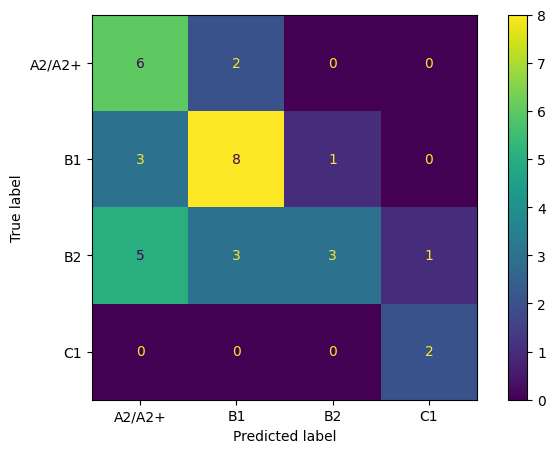

In [160]:
# vocabulary=words['name'].unique()
# 
vectorizer = TfidfVectorizer(**estimator[0].get_params(deep=True))
vectorizer.fit(x)

vect_x = vectorizer.transform(x)

nm = NearMiss()
X_res, Y_res = nm.fit_resample(vect_x, y)
pipeline2 = Pipeline( steps = [("base", RandomForestClassifier() )]  )
# CatBoostClassifier(task_type='GPU')
param_grid2 = {
    "base__n_estimators": [i for i in range(150,250,50)],
    "base__max_depth": [i for i in range(10,60,5)],
    "base__min_samples_split":[i for i in range(2,4,2)],
    "base__min_samples_leaf": [2],
}
estimator2 = search_best_estimator(pipeline2, param_grid2, X_res, Y_res)
X_train, X_test, y_train, y_test = train_test_split(
    vect_x, y, random_state=42, test_size=0.3, stratify=y
)
estimator2.fit(X_res, Y_res)
y_preds2 = estimator2.predict(X_test)
plot_confusion_matrix(y_test, y_preds2, estimator2)


In [161]:
report = classification_report(y_test, y_preds2, target_names=[
    'C1',
    'B2',
    'B1',
    'A2/A2+'
])
print(report)

              precision    recall  f1-score   support

          C1       0.43      0.75      0.55         8
          B2       0.62      0.67      0.64        12
          B1       0.75      0.25      0.38        12
      A2/A2+       0.67      1.00      0.80         2

    accuracy                           0.56        34
   macro avg       0.62      0.67      0.59        34
weighted avg       0.62      0.56      0.53        34



In [162]:
print( f' Model F1-score: {f1_score(y_test, y_preds2, average="weighted")}' )

 Model F1-score: 0.5336363636363637


Fitting 3 folds for each of 8 candidates, totalling 24 fits


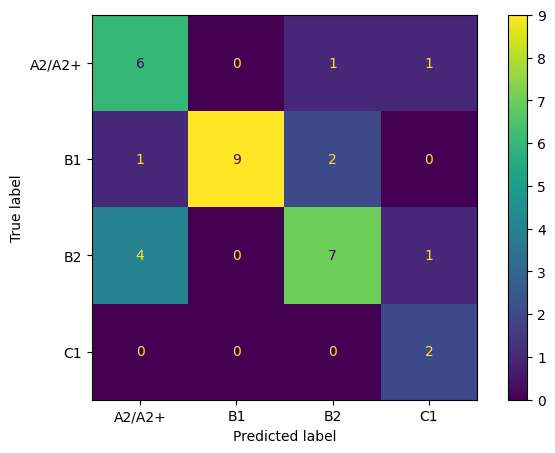

In [163]:
vect_x = vectorizer.transform(x)
vect_x = sparse.hstack((sparse.csr_matrix(df_films_splitted[['mean','median']].values), vect_x))

nm = NearMiss()
X_res, Y_res = nm.fit_resample(vect_x, y)
pipeline2 = Pipeline( steps = [("base", RandomForestClassifier() )]  )

param_grid2 = {
    "base__n_estimators": [i for i in range(150,250,50)],
    "base__max_depth": [i for i in range(25,35,5)],
    "base__min_samples_split":[i for i in range(6,10,2)],
    "base__min_samples_leaf": [2],
}
estimator2 = search_best_estimator(pipeline2, param_grid2, X_res, Y_res)
X_train, X_test, y_train, y_test = train_test_split(
    vect_x, y, random_state=42, test_size=0.3, stratify=y
)
estimator2.fit(X_res, Y_res)
y_preds2 = estimator2.predict(X_test)
plot_confusion_matrix(y_test, y_preds2, estimator2)

In [164]:
feature_importances = pd.DataFrame(estimator2[0].feature_importances_, index=vectorizer.get_feature_names() + ['mean','median'], columns=['importances']).sort_values(by='importances', ascending=False)

c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [165]:
print( f' Model F1-score: {f1_score(y_test, y_preds2, average="weighted")}' )

 Model F1-score: 0.7149424363046654


In [1]:
vect_x = vectorizer.transform(x)
vect_x = sparse.hstack((sparse.csr_matrix(df_films_splitted[['mean','median']].values), vect_x))

nm = NearMiss()
X_res, Y_res = nm.fit_resample(vect_x, y)
pipeline3 = Pipeline( steps = [("base", CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=100, task_type='GPU') )]  )
# CatBoostClassifier(task_type='GPU')
param_grid3 = {
    # "base__n_estimators": [i for i in range(200,300,50)],
    # "base__max_depth": [i for i in range(25,35,5)],
    # "base__min_samples_split": [i for i in range(8,12,2)],
    'base__learning_rate': [0.01,0.02,0.03,0.04],
}
estimator3 = search_best_estimator(pipeline3, param_grid3, X_res, Y_res)
X_train, X_test, y_train, y_test = train_test_split(
    vect_x, y, random_state=42, test_size=0.3, stratify=y
)
estimator3.fit(X_res, Y_res)
y_preds3 = estimator3.predict(X_test)
plot_confusion_matrix(y_test, y_preds3, estimator3)

NameError: name 'vectorizer' is not defined

In [170]:
print( f' Model F1-score: {f1_score(y_test, y_preds3, average="weighted")}' )

 Model F1-score: 0.6437417072091994


In [65]:
# https://stackoverflow.com/a/69678207
# https://habr.com/ru/post/702626/